# Fitting the LRpS estimator to stock data
**(Runtime: ~ 15 minutes)**

In order to show how to use the main functions of the package, we apply the LRpS estimator to some financial data. 

We look at the returns of the companies of the S&P500. We how show to perform cross-validation and fit a regularisation path.

In [1]:
library("lrpsadmm")

library(ggplot2)
library(reshape2)

Warning message:
“package ‘ggplot2’ was built under R version 3.4.4”

In [4]:
# Load the data downloaded and processed in another notebook
load("./data/sp500_data.RData")

The dataset we are playing with here has the following dimensions

In [ ]:
dim(detrended.returns)

## Fitting the model using cross-validation

### Background 

We recall quickly the function seek to minimise:
$$\arg \min_{S, L} - \log \det (S - L) + Trace((S - L) \Sigma) + \lambda (\gamma ||S||_1 + (1 - \gamma)Tr(L)),$$
such that $S-L$ is positive definite and $L$ is positive semi-definite. Here $\lambda >0, \gamma \in (0,1)$ are 
tuning parameters. $\gamma$ controls the trade-off between the trace and $\ell_1$ penalties. A small value of $\gamma$ will result in a low-rank $L$ in comparison to the $\ell_1$-norm of $S$. On the other hand, $\gamma$ large will encourage the learning of many eigenvectors in $L$ and a very sparse $S$. 

Whenever a new eigenvalue is added in $L$, $p$ parameters  are added to the model. In most applications where $n$ is not very large compared to $p$, one must be careful not to pick too high a value of $\gamma$. This would result in a matrix $L$ with many non-zero eigenvalues and a model with many parameters: the problem would become singular. 

### Cross-validation to pick $\lambda, \gamma$

Here, we use cross-validation to find sensible values of the tuning parameters, even though we know that this has a tendency to overselect. This can be done with the ```lrpsadmm.cv``` function.

Given the number of stocks we should start with small values of gamma and see what is selected. This will most likely save time. 

Picking too large a value of gamma in an underpowered dataset typically leads to an ill-posed problem and the algorithm cannot converge. It is therefore usually a good idea to start with gamma small and increase its value if necessary.

The following commands should take < 10 minutes to run.

[1] "### Computing the path on the full dataset first ###"
[1] "Fitting with gamma= 0.03  and lambda= 4.18559634113144 Sparsity: 0.0142313335590647 Rank of L: 6"
[1] "Fitting with gamma= 0.03  and lambda= 1.66631591644691 Sparsity: 0.0268209848041781 Rank of L: 10"
[1] "Fitting with gamma= 0.03  and lambda= 0.663372314744937 Sparsity: 0.116969864869025 Rank of L: 14"
[1] "Fitting with gamma= 0.03  and lambda= 0.264093275246631 Sparsity: 0.408881501318476 Rank of L: 15"
[1] "### Now performing  3  fold cross validation. ###"
[1] "Lambda: 4.18559634113144 X-Val Log-lik: 145.058799299723 #Edges: 1387"
[1] "Lambda: 1.66631591644691 X-Val Log-lik: 101.407355095111 #Edges: 2614"
[1] "Lambda: 0.663372314744937 X-Val Log-lik: 90.3231803542455 #Edges: 11400"
[1] "Lambda: 0.264093275246631 X-Val Log-lik: 100.047842281234 #Edges: 39850"
[1] "Lambda: 0.105137426570642 X-Val Log-lik: 123.881147096842 #Edges: 68033"
Time difference of 9.374826 mins


Warning message in brewer.pal(n = length(A), name = "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”

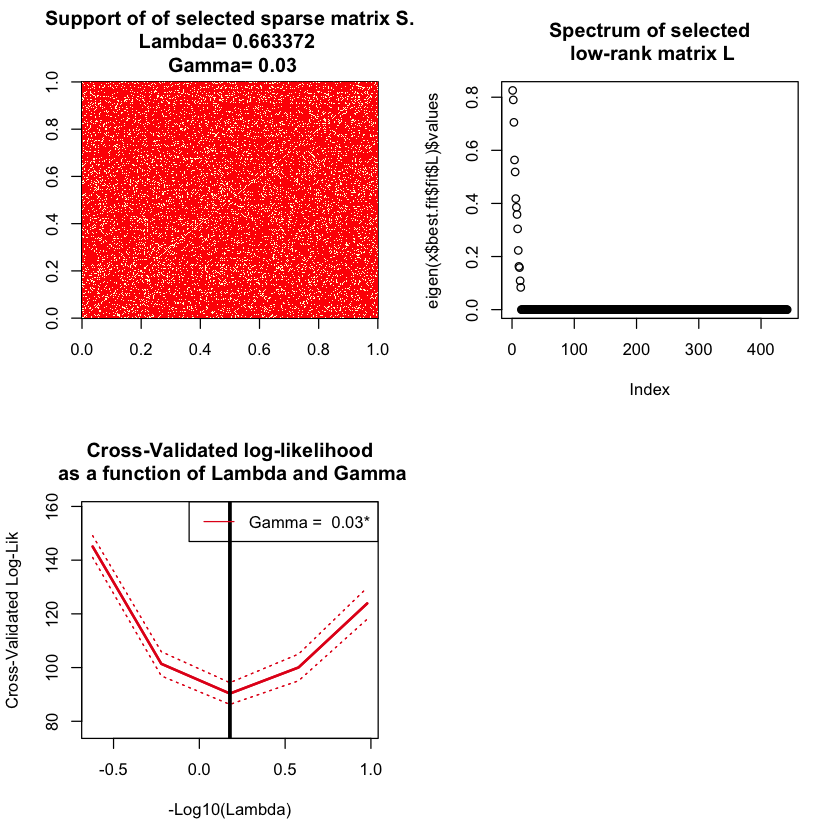

In [5]:
# And now fit using cross-validation.
# Here we try a single value of gamma.
start_time <- Sys.time()
lrpscv <- lrpsadmm.cv(X = detrended.returns, gammas = 0.03 , n.lambdas = 10, verbose = TRUE, n.folds = 3)
# You can also run this command: this will take ~ 40 minutes.
#lrpscv <- lrpsadmm.cv(X = detrended.returns, gammas = c(0.02, 0.03, 0.05) , n.lambdas = 20, verbose = TRUE, n.folds = 3)
end_time <- Sys.time()
print(end_time - start_time)
plot(lrpscv)

Let us look at some properties of the best fit:

In [6]:
print(paste("Lambda:", lrpscv$best.fit$lambda, "Gamma:", lrpscv$best.fit$gamma))
print(paste("Number of edges:", lrpscv$best.fit$number.of.edges, "Rank of low-rank matrix:", lrpscv$best.fit$rank.L))

[1] "Lambda: 0.663372314744937 Gamma: 0.03"
[1] "Number of edges: 11400 Rank of low-rank matrix: 14"


The regularisation path has also been computed:

In [7]:
# Path associated with the first value of gamma.
path <- lrpscv$cross.validated.paths[[1]]$cross.validated.path
# The value of gamma for which this path has been fitted
gamma <- path$gamma
# The fit corresponding to the value of Lambda selected by cross-validation
bf <- path$best.fit

## Looking at the path for the selected value of Gamma

Above cross-validation was used to pick the tuning parameters. We might also want to take a closer look at the path for the selected value of gamma (in this case 0.03).

This can be done using the ```lrpsadmm.path``` function.

In [9]:
Sigma <- cov(detrended.returns)
start_time <- Sys.time()
lrpspath <- lrpsadmm.path(Sigma = Sigma, gamma = 0.03, n = nrow(detrended.returns), max.rank = 30,
              lambda.ratio = 1e-02, n.lambdas = 30, verbose=TRUE)
end_time <- Sys.time()
print(end_time - start_time)

[1] "Fitting with gamma= 0.03  and lambda= 4.43735818487409 Sparsity: 0.0131847610839207 Rank of L: 5"
[1] "Fitting with gamma= 0.03  and lambda= 3.80590391574524 Sparsity: 0.0148674854557207 Rank of L: 6"
[1] "Fitting with gamma= 0.03  and lambda= 3.26430817896571 Sparsity: 0.0166835965155293 Rank of L: 7"
[1] "Fitting with gamma= 0.03  and lambda= 2.7997837368356 Sparsity: 0.0185099680898 Rank of L: 7"
[1] "Fitting with gamma= 0.03  and lambda= 2.40136302802538 Sparsity: 0.0202029529760622 Rank of L: 8"
[1] "Fitting with gamma= 0.03  and lambda= 2.05963922016518 Sparsity: 0.0222447953540391 Rank of L: 8"
[1] "Fitting with gamma= 0.03  and lambda= 1.76654411171263 Sparsity: 0.0247483608828147 Rank of L: 9"
[1] "Fitting with gamma= 0.03  and lambda= 1.51515763929581 Sparsity: 0.0283805830024317 Rank of L: 10"
[1] "Fitting with gamma= 0.03  and lambda= 1.29954449294268 Sparsity: 0.0334903192046049 Rank of L: 10"
[1] "Fitting with gamma= 0.03  and lambda= 1.11461398163332 Sparsity: 0.042

This took < 6 minutes. We can plot the output like so:

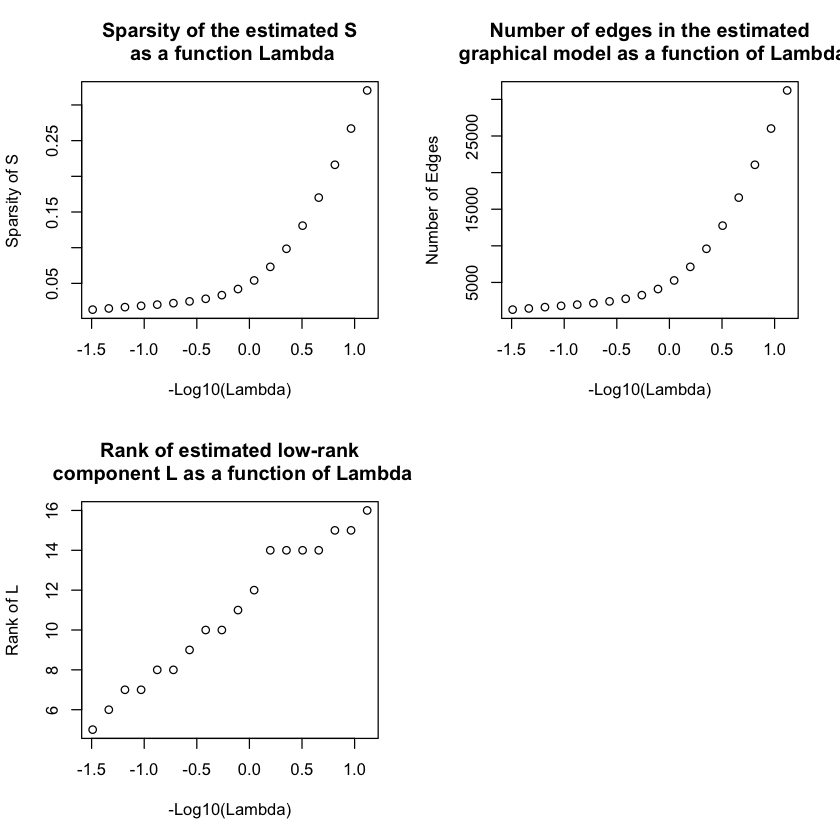

In [10]:
plot(lrpspath)

## Looking at a fit in more detail

Out of curiosity, let us take a look at what has been estimated by the low-rank and sparse components.

One guess is that the Industry or Sector of each stock plays a role in explaining the stock correlations.

In [11]:
Lhat = lrpscv$best.fit$fit$L
Shat = lrpscv$best.fit$fit$S

e1 <- eigen(Lhat)$vectors[,1]
e2 <- eigen(Lhat)$vectors[,2]
e3 <- eigen(Lhat)$vectors[,3]
e4 <- eigen(Lhat)$vectors[,4]

D <- cbind(e1, e2, e3, e4, industries)
D <- as.data.frame(D)
D[,1] <- as.numeric(as.character(D[,1]))
D[,2] <- as.numeric(as.character(D[,2]))
D[,3] <- as.numeric(as.character(D[,3]))
D[,4] <- as.numeric(as.character(D[,4]))
colnames(D) <- c("V1", "V2", "V3", "V4", "Industry")

It looks like some industries are properly identified but this is not great.

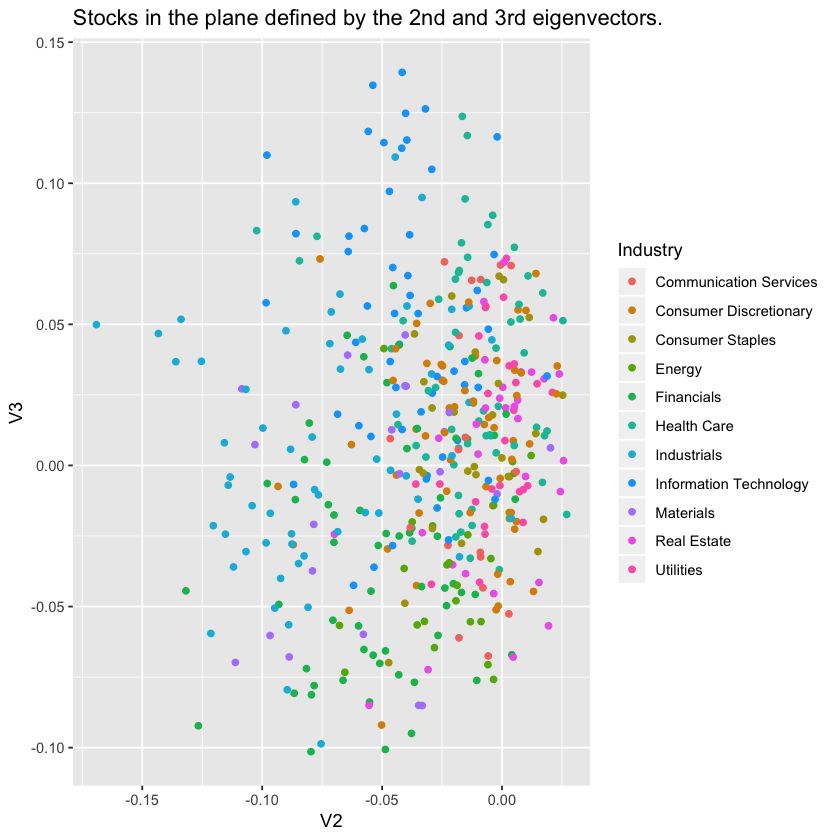

In [12]:
ggplot(D, aes(x=V2, y=V3)) + geom_point(aes(colour=Industry)) + ggtitle("Stocks in the plane defined by the 2nd and 3rd eigenvectors.")

We can also use the sparse matrix as an affinity matrix for KMeans clustering.

In [22]:
# A crude way of going from covariances to distances: take the inverse
A <- 1 - 1/cov2cor(Shat)
A[is.infinite(A)] <- 10 * 1/min(abs(cov2cor(Shat)[cov2cor(Shat)!=0]))
kmeansobj <- kmeans(A, 10)
D <- matrix(NA, nrow=0, ncol=2)
for(cluster in unique(kmeansobj$cluster)) {
    idx <- which(kmeansobj$cluster == cluster)
    ind <- industries[idx]
    D <- rbind(D, cbind(ind, rep(cluster, length(ind))))
}
D <- as.data.frame(D)
colnames(D) <- c("Industry", "Cluster")

Here, we plot histograms showing how many times a given industry shows up in a given cluster. It is clear that the sparse matrix S is itself mostly driven by industries. For example, Health Care has two clusters just for itself.

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

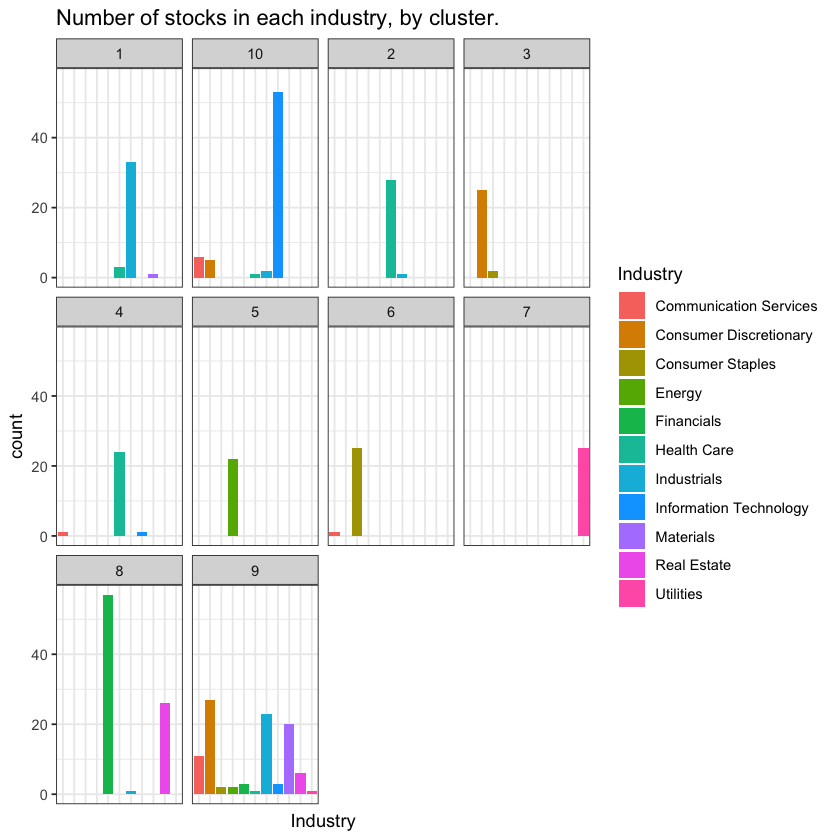

In [23]:
ggplot(D, aes(x=Industry)) + geom_histogram(stat="count", aes(fill=Industry)) + facet_wrap(~Cluster) + theme_bw() + 
ggtitle("Number of stocks in each industry, by cluster.") + 
theme(axis.text.x=element_blank(),
        axis.ticks.x=element_blank())